# Inference EfficientDet

In [1]:
import sys,os
sys.path.insert(0, "..")

In [2]:
from ensemble_boxes import *
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
from libs.efficientdet.effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from libs.efficientdet.effdet.efficientdet import HeadNet

from sklearn.model_selection import StratifiedKFold

In [3]:
marking = pd.read_csv("../taco/meta_df.csv").rename(
    columns={
        "img_file": "image_id",
        "width": "w",
        "height": "h",
        "img_width": "width",
        "img_height": "height"
    }
).drop(["img_id"], axis=1)
# marking["image_id"] = marking["image_id"].str.replace(r"\..+$", "")
marking["source"] = "s"
print(marking.shape)
sel = ( (marking["x"] > 0) & (marking["x"] < marking["width"]) 
& (marking["y"] > 0) & (marking["y"] < marking["height"])
 & (marking["w"] > 0) & (marking["w"] < marking["width"])
 & (marking["h"] > 0) & (marking["h"] < marking["height"])
& (marking["width"] > 800)
& (marking["height"] > 800)
)
marking = marking[sel].reset_index(drop=True)
print(marking.shape)
marking.head()

(4784, 13)
(4728, 13)


,width,height,image_id,cat_id,cat_name,supercategory,ann_id,x,y,w,h,area,source
0,1537,2049,batch_1/000006.jpg,6,Glass bottle,Bottle,1,517.0,127.0,447.0,1322.0,403954.0,s
1,1537,2049,batch_1/000008.jpg,18,Meal carton,Carton,2,1.0,457.0,1429.0,1519.0,1071259.5,s
2,1537,2049,batch_1/000008.jpg,14,Other carton,Carton,3,531.0,292.0,1006.0,672.0,99583.5,s
3,1537,2049,batch_1/000010.jpg,5,Clear plastic bottle,Bottle,4,632.0,987.0,500.0,374.0,73832.5,s
4,1537,2049,batch_1/000010.jpg,7,Plastic bottle cap,Bottle cap,5,632.0,989.0,44.0,51.0,915.0,s


In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 2}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

df_folds.head()

,bbox_count,source,stratify_group,fold
image_id,,,,
batch_1/000000.jpg,1,s,s_0,0
batch_1/000001.jpg,2,s,s_1,0
batch_1/000003.jpg,1,s,s_0,0
batch_1/000005.jpg,1,s,s_0,0
batch_1/000006.jpg,1,s,s_0,0


In [6]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [7]:
# DATA_ROOT_PATH = "data"
DATA_ROOT_PATH = "../datasets/wild-test-data"

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [8]:
os.listdir("../datasets/wild-test-data")

['20200816_192349.jpg',
 '20200816_192401.jpg',
 '20200816_192425.jpg',
 '20200816_192435.jpg',
 'alin-luna-O_ncews1Hxw-unsplash(1).jpg',
 'alin-luna-O_ncews1Hxw-unsplash.jpg',
 'alin-luna-O_ncews1Hxw-unsplash_rotation_cropping.jpg',
 'alin-luna-VwpvVCIExUE-unsplash.jpg',
 'brian-yurasits-5fbJMCzqNDs-unsplash.jpg',
 'canada-day-litter.jpg',
 'gallery_medium.jpg',
 'hadley-jin-6TujLSBUlUA-unsplash.jpg',
 'images (1).jpg',
 'images (2).jpg',
 'images (3).jpg',
 'images (4).jpg',
 'images (5).jpg',
 'images (6).jpg',
 'images.jpg',
 'john-cameron-FMrZLPdDyx4-unsplash.jpg',
 'julia-joppien-krCTg4cKtVQ-unsplash.jpg',
 'kevin-lehtla-tPJI_XIMDHE-unsplash.jpg',
 'markus-spiske-itAJUJlNmdE-unsplash.jpg',
 'masha-kotliarenko-WDIno7aLaQM-unsplash.jpg',
 'merch-husey-sDDOPRxh9nE-unsplash.jpg',
 'miguel-moebius-uAN5kzMvE5A-unsplash.jpg',
 'nick-shandra-m2Yp6ZyQJz8-unsplash.jpg',
 'NW-A00-24052018-BVjunctionGarbage1_large.jpeg',
 'pedro-aguilar-1PCJkDXyJjY-unsplash.jpg',
 'people-collecting-trash-wo

In [9]:
# dataset = DatasetRetriever(
#     image_ids=df_folds[df_folds['fold'] == 0].index.values,
#     transforms=get_valid_transforms(),
# )
dataset = DatasetRetriever(
    image_ids=np.array(os.listdir("../datasets/wild-test-data")),
    transforms=get_valid_transforms(),
)

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    collate_fn=collate_fn
)

In [12]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
device

device(type='cpu')

In [15]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.to(device)

# net = load_net('../input/wheat-effdet5-fold0-best-checkpoint/fold0-best-all-states.bin')
net = load_net('../checkpoints/best-checkpoint-012epoch.bin')

In [16]:
def make_predictions(images, score_threshold=0.22):
    images = torch.stack(images).to(device).float()
    predictions = []
    with torch.no_grad():
        det = net(images, torch.tensor([1]*images.shape[0]).float().to(device))
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [17]:
# len(dataset)

In [18]:
# cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 0, 1), 3)

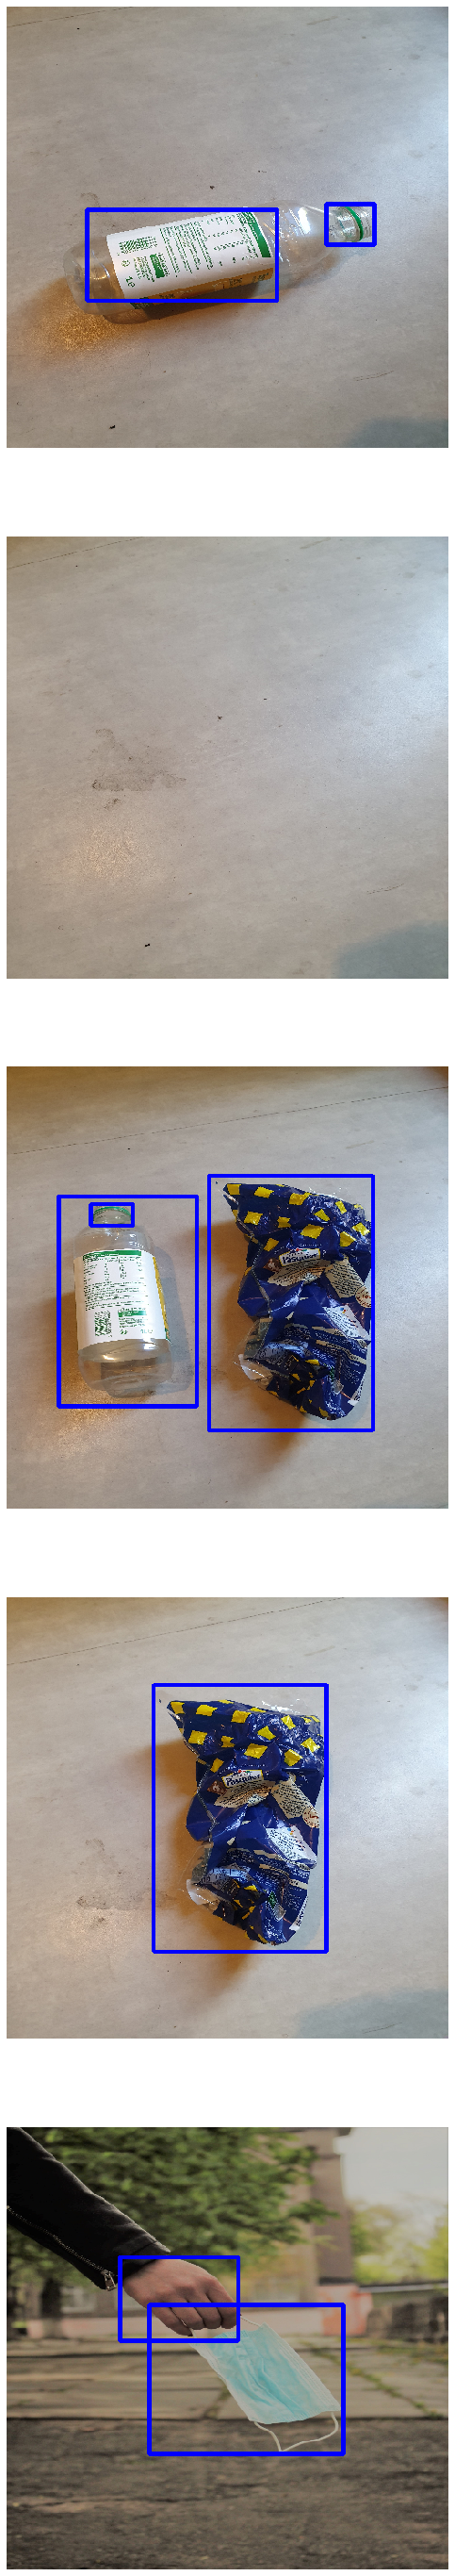

In [19]:
import matplotlib.pyplot as plt

# for j, (images, image_ids) in enumerate(data_loader):
#     break
# fig, axes = plt.subplots(len(dataset), 1)
N = min(5,len(dataset))
fig, axes = plt.subplots(N, 1, figsize=(30, 10*N))
for j,ax in enumerate(axes):
    images, image_ids = dataset[j]
    # images = torch.from_numpy(images[None]).to(device)
    # images = images[None].to(device)
    images = [images]
    predictions = make_predictions(images)

    i = 0
    sample = images[i].permute(1,2,0).cpu().numpy()

    boxes, scores, labels = run_wbf(predictions, image_index=i)
    boxes = boxes.astype(np.int32).clip(min=0, max=511)

#     fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 0, 1), 3)

    ax.set_axis_off()
    ax.imshow(sample)
# plt.tight_layouts()